<div>
<img src="https://www.automation.com/getmedia/3c46e651-52ef-4d7e-9ee1-4e2132173f57/EUS031---Image" width="250" align="left"/>
</div>

## Reinforcement Learning Final Project: Inventory Management
Group 6: Michael, Annie, Targoon

In [ ]:
# 1. Problem Introduction
    # - EDA / Markov Process Description
# 2. Solve Problem in a small scale (Value Iteration)
    # - Calculate Probability Matrix & Rewards by simulation
    # - plot different graphs between optimal action vs initial state given different values
# 3. Increase problem scaling (Value Iteration with Simulation & Q-Learning)

### Necessary imports

In [1]:
#!!pip install gym
#!pip install quantecon 
#!pip install numpy==1.19.1

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import logging
logger = logging.getLogger(__name__)

import os
from os.path import basename
import sys
import platform

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import pandas as pd
import numpy as np
import quantecon as qe

import matplotlib.pyplot as plt

from collections import Counter
from itertools import groupby

import warnings
warnings.filterwarnings("ignore") # supress warnings

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', 20) # set max row display
pd.set_option('display.max_columns', 20) # set max column width

# enable ability to see the value of multiple statements at once
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

/Users/colella2/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
# check python version
from platform import python_version
print(python_version())

3.7.7


### Instantiate class from gym environment

In [3]:
class InventoryEnv(gym.Env, utils.EzPickle):
    """Inventory control with lost sales environment

    TO BE EDITED

    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    # our problem statement does not fully define these parameters
    # we will explain what happens to our optimal policy, given changing parameters -- we will show this w/ graphs
    
    def __init__(self, n=10, k=1, c=2, h=0, p=5, lam=5): # default values
        self.n = n # items held at certain time
        self.action_space = spaces.Discrete(n + 1)
        self.observation_space = spaces.Discrete(n + 1)
        self.max = n # have to optimize max items held at certain time
        self.state = np.random.choice(range(n + 1))
        self.k = k # fixed entry cost for ordering; k must be greater than 0
        self.c = c # fixed price of purchase for items
        self.h = h # proportionality value must be greater than 0; cost per unit; constant that we multiply by remaining inventory
        self.p = p # p is price and must be greater than 0
        self.lam = lam # trace-decay parameter; makes algo incremental
        
        # we do not know what demand will be 
        # upon selling z units the manager is paid the monetary amount of p z, where p > 0.

        # Set seed
        self._seed()

        # Start the first round
        self._reset()

    def demand(self):
        return np.random.poisson(self.lam) # randomly generated demand based on poisson distribution

    # transition probabilities
    def transition(self, x, a, d): # action At gives the number of items ordered in the evening of day t
        # x is initial state
        
        m = self.max
        
        # size of next inventory is xt+1
        return max(min(x + a, m) - d, 0) # subtract the d (demand) that you will recieve the next day

    # a controller receives the controlled system's state and a reward associated with the last state transition
    def reward(self, x, a, y):
        k = self.k
        m = self.max # m is equal to n
        c = self.c
        h = self.h
        p = self.p
        
        # a, amount purchased, + max inventory; if over amount of storage, affix penalty
        if a + x > self.max:
            return -99999
        else:
            r = -k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
            return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        obs = self.state
        demand = self.demand()
        obs2 = self.transition(obs, action, demand)
        self.state = obs2
        reward = self.reward(obs, action, obs2)
        done = 0
        return obs2, reward, done, {}

    def _reset(self):
        return self.state

We are going to start with a smaller sample set.

### Step 1: Transition probability and Reward matrices

In [4]:
env = InventoryEnv()
env.n

10

In [5]:
#env = updated gym env
#T= simulated demand iterations 

def transition_prob(env,T=10000):
  P_t = np.zeros([env.n + 1, env.n + 1, env.n + 1]) #(action, current_state, next_state)
  RR = np.zeros([env.n + 1, env.n + 1, env.n + 1]) 
  print('Shape of probability matrix and Reward Matrix is',RR.shape)

  demand_list = []
  for init_state in range(env.n + 1):
      for action in range(env.n + 1):
          final_state_list = []

          for i in range(T):
              demand = env.demand()
              final_state = env.transition(init_state, action, demand)
              
              demand_list.append(demand)
              final_state_list.append(final_state)
              
          final_state_count = Counter(final_state_list)
          
          
          for (final_state,probability) in final_state_count.items():
              P_t[action, init_state, final_state] = probability / T
              
          for final_state in range(env.n + 1):
              RR[action, init_state, final_state] = env.reward(init_state, action, final_state)

  return P_t,RR,demand_list

In [6]:
P_t,RR,demand_list = transition_prob(env)

Shape of probability matrix and Reward Matrix is (11, 11, 11)


(array([4.90880e+04, 2.71929e+05, 4.24741e+05, 3.03014e+05, 1.22712e+05,
        3.18010e+04, 5.83400e+03, 7.93000e+02, 7.90000e+01, 9.00000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

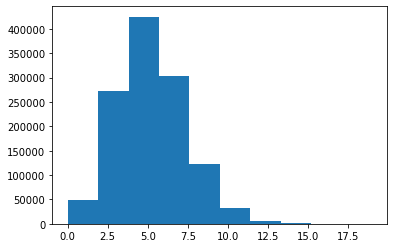

In [7]:
plt.hist(demand_list)

In [8]:
pd.DataFrame(P_t[5,:,:])

,0,1,2,3,4,5,6,7,8,9,10
0,0.5666,0.1734,0.1359,0.0835,0.0328,0.0078,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3868,0.1720,0.1712,0.1414,0.0857,0.0357,0.0072,0.0000,0.0000,0.0000,0.0000
2,0.2366,0.1426,0.1745,0.1734,0.1491,0.0825,0.0331,0.0082,0.0000,0.0000,0.0000
3,0.1370,0.1046,0.1403,0.1811,0.1760,0.1332,0.0855,0.0352,0.0071,0.0000,0.0000
4,0.0682,0.0604,0.1052,0.1449,0.1745,0.1794,0.1379,0.0884,0.0358,0.0053,0.0000
5,0.0275,0.0354,0.0624,0.1045,0.1469,0.1772,0.1721,0.1472,0.0864,0.0334,0.0070
6,0.0349,0.0356,0.0632,0.0964,0.1450,0.1751,0.1820,0.1422,0.0842,0.0346,0.0068
7,0.0306,0.0330,0.0652,0.1026,0.1475,0.1801,0.1784,0.1441,0.0800,0.0309,0.0076
8,0.0354,0.0375,0.0641,0.0996,0.1442,0.1732,0.1747,0.1418,0.0856,0.0358,0.0081
9,0.0325,0.0357,0.0638,0.1056,0.1467,0.1731,0.1754,0.1404,0.0825,0.0380,0.0063


In [9]:
K,N,M = P_t.shape
K,N,M

(11, 11, 11)

In [10]:
# k = action
# i = current state
# j = next state

### Step 2: EDA

In [11]:
# transition probability is dependent on action(s) taken
# note: it is possible for MDP's to have absorbing states

# all probabilities should be betw. 0 and 1, which they already are
# confirm values are as expected

P_t[0,:,:] # use array 0 as example

P_t[0,:,:].shape

# sum to validate probabilities add to 1
np.sum(P_t[0,:,:], axis = 1)


# for z in range(0,11):
#    P_t[z,:,:]
#    P_t[z,:,:].shape
#    np.sum(P_t[z,:,:], axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
prob_matrix = P_t[0]
prob_matrix

array([[1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.9932, 0.0068, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.9591, 0.0347, 0.0062, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.8699, 0.0886, 0.0338, 0.0077, 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.7327, 0.1456, 0.0826, 0.0325, 0.0066, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.5605, 0.1759, 0.1383, 0.0852, 0.0347, 0.0054, 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.3848, 0.1725, 0.1818, 0.1347, 0.083 , 0.036 , 0.0072, 0.    ,
        0.    , 0.    , 0.    ],
       [0.2413, 0.1478, 0.1733, 0.1723, 0.1435, 0.083 , 0.0331, 0.0057,
        0.    , 0.    , 0.    ],
       [0.1336, 0.1076, 0.1438, 0.1742, 0.1713, 0.146 , 0.0833, 0.0337,
        0.0065, 0.    , 0.    ],
       [0.072 , 0.0706, 0.1059, 0.1482, 0.1755, 0.1725,

In [16]:
# define # of periods / decision epochs / stages
T = 100

# define # of rows & cols
n = 11

# create array for storing transition probs
P = np.zeros((T,n,n),dtype=np.float64) # reflects steps 0 through 99

P.shape

(100, 11, 11)

In [17]:
# take first array of 0's and set equal to first set of transition probabilities
P[0] = prob_matrix
P[0]

array([[1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.9932, 0.0068, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.9591, 0.0347, 0.0062, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.8699, 0.0886, 0.0338, 0.0077, 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.7327, 0.1456, 0.0826, 0.0325, 0.0066, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.5605, 0.1759, 0.1383, 0.0852, 0.0347, 0.0054, 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.3848, 0.1725, 0.1818, 0.1347, 0.083 , 0.036 , 0.0072, 0.    ,
        0.    , 0.    , 0.    ],
       [0.2413, 0.1478, 0.1733, 0.1723, 0.1435, 0.083 , 0.0331, 0.0057,
        0.    , 0.    , 0.    ],
       [0.1336, 0.1076, 0.1438, 0.1742, 0.1713, 0.146 , 0.0833, 0.0337,
        0.0065, 0.    , 0.    ],
       [0.072 , 0.0706, 0.1059, 0.1482, 0.1755, 0.1725,

In [24]:
for item in range(1,T):
    P[item] = np.matmul(P[item - 1], prob_matrix)

In [25]:
# map actions
states = {
    
    0:'state1', 
    1:'state2', 
    2:'state3', 
    3:'state4', 
    4:'state4', 
    5:'state5', 
    6:'state6', 
    7:'state7',
    8:'state8',
    9:'state9',
    10:'state10'
    
}

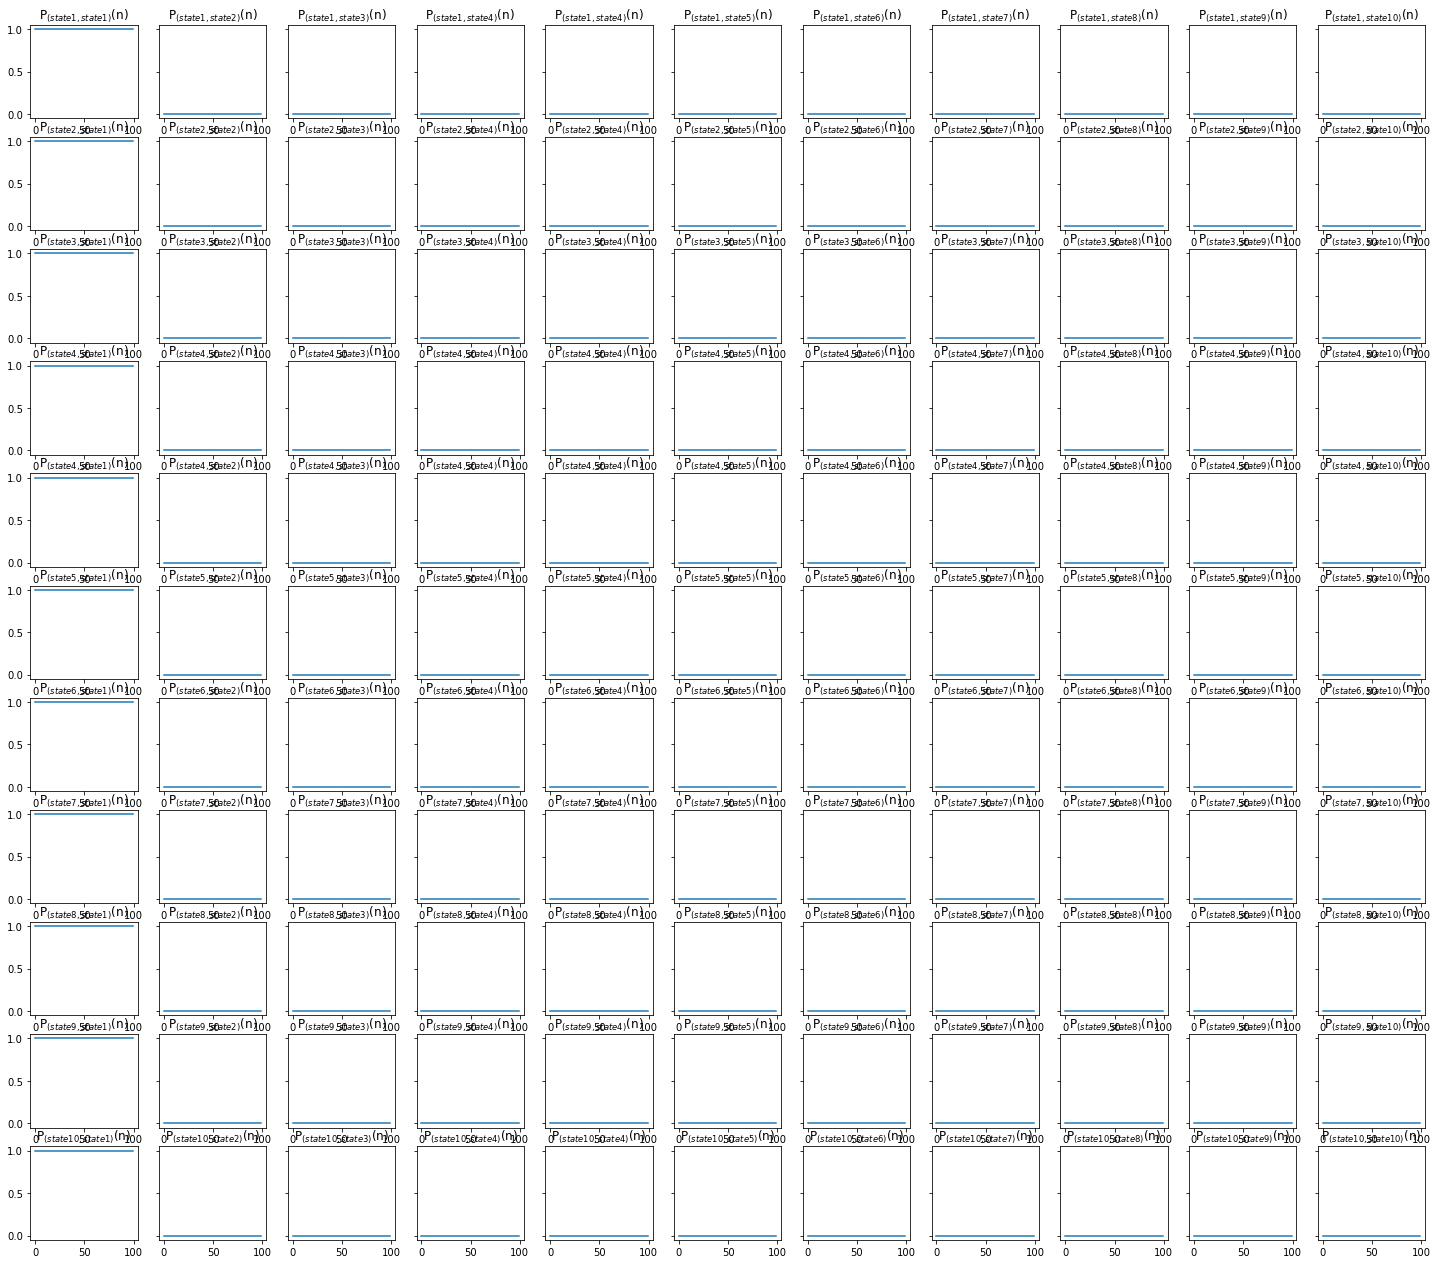

In [26]:
# plot
fig, axes = plt.subplots(n, n, figsize=(25, 25), sharey = True)

for i in range(n):
    
    for j in range(n):
        
        var_name = '({},{})'.format(states[i],states[j])
        
        plt.sca(axes[i, j]) 
        plt.plot(range(T), P[:,i,j])
        
        axes[i,j].set_title(f'P$_{{{var_name}}}$(n)')

fig.subplots_adjust(top = 0.8)
plt.show()

In [30]:
# Group all states into classes. Report the classes and the total number of classes.
im_states = qe.MarkovChain(prob_matrix, ('state1', 'state2', 'state3','state4','state5','state6','state7',
                                         'state8', 'state9', 'state10', 'state11'))

# calculate communication classes
print(im_states.communication_classes) 

[array(['state1'], dtype='<U7'), array(['state2'], dtype='<U7'), array(['state3'], dtype='<U7'), array(['state4'], dtype='<U7'), array(['state5'], dtype='<U7'), array(['state6'], dtype='<U7'), array(['state7'], dtype='<U7'), array(['state8'], dtype='<U7'), array(['state9'], dtype='<U7'), array(['state10'], dtype='<U7'), array(['state11'], dtype='<U7')]


In [31]:
# get # of classes
len(im_states.communication_classes)

11

In [32]:
print(im_states.is_irreducible)

False


In [34]:
# periodicity

# remove variable names for credit ratings
im_states2 = qe.MarkovChain(prob_matrix)

# calculate # of periods
im_states2.period

# since the # of periods = 1, this means the matrix is aperiodic, something confirmed by 
# the plots with no discernable pattern

1

In [35]:
# shows matrix is aperiodic
im_states2.is_aperiodic 

True

In [41]:
# simulation

# construct a 100-step simulation assuming an intial state0 rating and the above transition matrix
simulations = 1000

simulation = im_states.simulate(simulations, init = 'state1', random_state = 33)
simulation

array(['state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'state1',
       'state1', 'state1', 'state1', 'state1', 'state1', 'stat

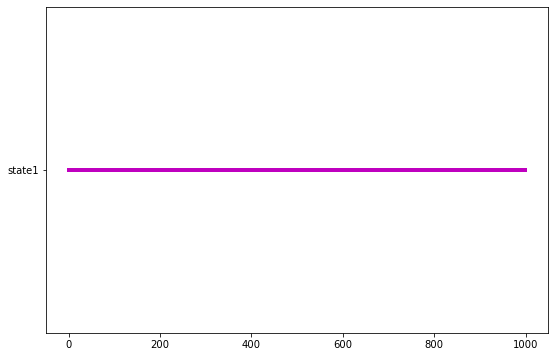

In [42]:
# plot sequence of transitions as step function of time

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(simulation, lw = 4, color = 'm')

In [44]:
# Report the likehood of each transition and the likelihood of the entire simulated sequence

# sequence probability for all steps -- 100
probability = 1

# transition probability set
prob_set = []


for i in range(1, simulations):
    
    # current state -- state 1
    c_s = simulation[i - 1]
    
    # following state -- state 2
    f_s = simulation[i]
    
    c_s_index = list(states.keys())[list(states.values()).index(c_s)]
    f_s_index = list(states.keys())[list(states.values()).index(f_s)]
    
    # transition probability
    prob_set2 = prob_matrix[c_s_index,f_s_index]
    prob_set2 = round(prob_set2,3)
    
    # append new transition probabilities
    prob_set.append(((c_s, f_s), prob_set2))
    
    # multiply sequence probabilities by calculated probabilities
    probability *= prob_set2

In [45]:
# likelihood of each transition
prob_set

[(('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1', 'state1'), 1.0),
 (('state1

In [46]:
# Likelihood of entire simulated sequencen (total):
probability

1.0

In [48]:
# stationarity
# Is this Markov chain stationary?

# stationary distribution

a = np.ones((n,)) 
b = np.ones((n, n))

i = np.identity(11)

p = np.matmul(a,np.linalg.inv(i - prob_matrix + b)) 
# linalg.inv() calculates inverse of matrix
# inverse of a matrix is such that if multiplied by original matrix, results in identity
# matrix
# identity matrix is square matrix with ones on main diagonal

p

array([ 1.00000000e+00,  5.55111512e-17, -9.54097912e-17, -9.54097912e-17,
        9.02056208e-17, -1.38777878e-17, -7.63278329e-17, -2.77555756e-17,
        1.14491749e-16,  2.77555756e-17,  0.00000000e+00])

In [49]:
# can confirm stationary by multiplying by transition probability matrix
p = np.matmul(p, prob_matrix)
p

array([ 1.00000000e+00, -3.68368530e-18,  2.43208231e-18,  1.00088340e-17,
        1.42792028e-17,  1.63771774e-17,  1.17215265e-17,  5.98722460e-18,
        1.68511038e-18,  2.05391260e-19,  0.00000000e+00])

In [51]:
# confirm stationarity with quant econ function
im_states.stationary_distributions

# stationary distrib. of a Markov chain is a prob. distrib. that remains unchanged in the 
# Markov chain over time

# Markov chain is stationary b/c of existence of stationary distribution & b/c it satisfies 
# mathematical condition of pi^T = pi^T * P. pi is a row vector with probabilities that sum 
# to 1

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# is this Markov chain time homogeneous?

# The Markov chain is _________ due to stationarity of transition probabilities. So, the
# probability of visiting a future state _________ on present state. The probability 
# transition matrix _________ depend on time. The probability of visiting a future state is
# __________given any current state.

In [ ]:
# recurrent states -- including explanation(s)


### Step 3: Value Iteration

In [52]:
def value_iteration(P_t,RR,t=600):
    
  K,N,M = P_t.shape
  q = np.zeros((K,N,1),dtype=np.float64)
  # print(q)
    
  print('The shape of K,N,M is:', K,N,M) 
  print('The shape of q is:',q.shape) # creates eleven 11 x 1 arrays
    
  for i in range(0,N):
    for k in range(0,K):
        for j in range(0,M):
            q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]

  v = np.zeros((N,t),dtype=np.float64)
  d = np.zeros((N,t),dtype=np.float64)
    
  for n in range(1,t):   
      for i in range(0,N):
          rhs = np.zeros((1,K),dtype=np.float64)
        
          for k in range(0,K):
              rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
            
          v[i,n] = max(rhs[0])
          d[i,n] = np.argmax(rhs[0])
  
  v = v.T
  d = d.T

  return v,d

In [53]:
v,d=value_iteration(P_t,RR)

The shape of K,N,M is: 11 11 11
The shape of q is: (11, 11, 1)


In [54]:
value_df = pd.DataFrame(v)
value_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.670500,11.616000,13.536500,15.591000,17.826500,20.630500,22.523000,23.806000,24.396500,25.021500,24.967000
2,23.717773,25.837398,27.804539,29.736907,31.701714,33.705077,35.799262,38.040181,40.503599,42.907121,44.753223
3,37.824375,39.818409,41.897186,43.764043,45.802498,47.684863,49.815877,52.038564,54.402511,56.818865,58.878335
4,51.838308,53.832903,55.912346,57.778184,59.817804,61.698778,63.831056,66.095537,68.447745,70.851207,72.893459
...,...,...,...,...,...,...,...,...,...,...,...
595,8338.960673,8340.955353,8343.034617,8344.900791,8346.940249,8348.821408,8350.953483,8353.210478,8355.563910,8357.969900,8360.015583
596,8352.982874,8354.977555,8357.056819,8358.922993,8360.962450,8362.843609,8364.975684,8367.232680,8369.586111,8371.992102,8374.037784
597,8367.005076,8368.999756,8371.079020,8372.945194,8374.984651,8376.865811,8378.997886,8381.254881,8383.608313,8386.014303,8388.059986
598,8381.027277,8383.021958,8385.101222,8386.967396,8389.006853,8390.888012,8393.020087,8395.277082,8397.630514,8400.036505,8402.082187


In [55]:
policy_df = pd.DataFrame(d)
policy_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,10
590,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
591,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
592,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
593,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
594,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
595,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
596,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
597,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
598,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
599,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0


### Step 4: Value Iteration by Simulation

In [56]:
a = P_t.sum(axis=1)
a.shape

(11, 11)

In [57]:
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9,10
0,5.9765,0.9891,0.9335,0.8595,0.7628,0.6213,0.4271,0.2565,0.1232,0.0420,0.0085
1,4.9983,1.0057,1.0036,0.9725,0.9187,0.7931,0.6096,0.4078,0.2076,0.0708,0.0123
2,4.0417,1.0372,1.0715,1.0710,1.0731,0.9503,0.7870,0.5442,0.2924,0.1096,0.0220
3,3.1101,1.0447,1.1075,1.2031,1.2041,1.1309,0.9678,0.6930,0.3727,0.1403,0.0258
4,2.2714,0.9948,1.1580,1.2584,1.3525,1.3020,1.1574,0.8319,0.4606,0.1771,0.0359
5,1.5911,0.8642,1.1144,1.3397,1.4970,1.4937,1.3191,0.9916,0.5394,0.2078,0.0420
6,1.0384,0.7443,1.0687,1.3746,1.5892,1.6521,1.5012,1.1185,0.6178,0.2464,0.0488
7,0.6817,0.6163,0.9498,1.3296,1.6738,1.7978,1.6698,1.2478,0.7114,0.2666,0.0554
8,0.4964,0.4828,0.8374,1.2680,1.6546,1.9053,1.8250,1.3695,0.7983,0.3055,0.0572
9,0.3823,0.4293,0.7491,1.1948,1.6329,1.9636,1.8717,1.5033,0.8613,0.3417,0.0700


In [58]:
a.sum(axis=1)

array([11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.])

In [59]:
np.set_printoptions(precision=15)

In [60]:
P_t[9,:,:]

array([[0.0639, 0.0676, 0.1032, 0.1538, 0.1723, 0.1722, 0.1433, 0.0816,
        0.0342, 0.0079, 0.    ],
       [0.0316, 0.0343, 0.0643, 0.1062, 0.145 , 0.1789, 0.1735, 0.1437,
        0.0852, 0.0317, 0.0056],
       [0.0332, 0.0374, 0.0621, 0.1019, 0.1416, 0.1767, 0.1752, 0.1456,
        0.0851, 0.0336, 0.0076],
       [0.029 , 0.0397, 0.0636, 0.1049, 0.1474, 0.1787, 0.1705, 0.1425,
        0.082 , 0.0336, 0.0081],
       [0.0306, 0.0372, 0.0639, 0.1035, 0.1456, 0.1831, 0.1733, 0.1436,
        0.0803, 0.033 , 0.0059],
       [0.0337, 0.0362, 0.0645, 0.1079, 0.1476, 0.1755, 0.1701, 0.1435,
        0.0818, 0.0324, 0.0068],
       [0.0294, 0.0354, 0.0646, 0.1101, 0.1449, 0.177 , 0.1738, 0.1365,
        0.085 , 0.0364, 0.0069],
       [0.0331, 0.0339, 0.0631, 0.0975, 0.1541, 0.1766, 0.176 , 0.1426,
        0.0821, 0.033 , 0.008 ],
       [0.0348, 0.0328, 0.067 , 0.1061, 0.1422, 0.1796, 0.1713, 0.146 ,
        0.0817, 0.0311, 0.0074],
       [0.0317, 0.0353, 0.0679, 0.1001, 0.1464, 0.1853,

In [61]:
#T= number of episodes 
# maximum number of transitions (=maximum number of simulations -1)


def val_iter_sim(P_mat,RR,T=1000,Tmax=1000):
  K,N,M = P_t.shape
  # compute the expected reward (immediate)
  q = np.zeros((K,N,1),dtype=np.float64)

  for i in range(0,N):
      for k in range(0,K):
          for j in range(0,M):
              q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]


  v = np.zeros((N,T+1),dtype=np.float64)
  d = np.zeros((N,T+1),dtype=np.int)
  visits = np.zeros((N,1),dtype=np.int)



  for n in range(1,T):
      t = 1
      y0 = N-1
      while (t<=Tmax+1):
          visits[y0]+=1
          for i in range(0,N):
              if i==y0:
                  rhs = np.zeros((1,K),dtype=np.float64)
                  for k in range(0,K):
                      rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
                  v[i,n] = max(rhs[0])
                  if np.random.uniform(0,1,1)>=0.1:
                      d[i,n] = np.argmax(rhs[0])
                  else:
                      d[i,n] = np.random.choice(range(0,K))
          y1 = np.random.choice(range(0,N),p=P_t[d[y0,n],y0,:])
          y0 = y1
          t = t+1
      v[:,n+1] = v[:,n]
      d[:,n+1] = d[:,n]
      
  v = v.T
  d = d.T
  return v,d, visits

In [62]:
%%time

v,d,visits=val_iter_sim(P_t,RR)

CPU times: user 1min 12s, sys: 989 ms, total: 1min 13s
Wall time: 1min 13s


In [63]:
pd.DataFrame(d)

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,0
1,8,4,3,2,0,0,0,0,4,0,0
2,9,8,8,6,6,4,3,0,0,0,0
3,10,9,8,7,6,5,4,0,0,0,0
4,10,9,8,7,9,5,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
996,10,9,8,7,6,5,4,0,0,0,0
997,10,3,8,7,6,5,4,0,0,0,0
998,10,9,8,7,7,5,4,0,0,0,0
999,10,9,8,7,6,5,4,0,0,0,0


### Step 5: Q-Learning

In [64]:
# Tmax=maximum number of transitions (=maximum number of simulations -1)

def Q_learning(env=env,lr=0.01,Tmax=1000,T=1000):

  v = np.zeros((env.n + 1,T+1),dtype=np.float64) #value
  d = np.zeros((env.n + 1,T+1),dtype=np.int) #policy
  visits = np.zeros((env.n + 1,env.n + 1),dtype=np.int) #current/action

  Q = np.zeros((env.n + 1,env.n + 1),dtype=np.float64)

  learning_rate = lr
  for num_ep in range(1,T):
      t = 1
      current_state = env.state
      while (t <= Tmax+1):
          if t < Tmax / 2:
              if np.random.uniform(0,1,1)>=((Tmax - t) / Tmax):
                  action = np.argmax(Q[current_state,:]) #greedy
              else:
                  action = np.random.choice(range(0,K)) #explore
          else:
              action = np.argmax(Q[current_state,:]) #greedy
          visits[current_state,action]+=1
          #print("state: " + str(env.state))
          next_state, reward, done, z = env._step(action)
          #print("action: " + str(action))
          #print("next state: " + str(env.state))
          
          Q[current_state,action] = (1-learning_rate)*Q[current_state,action] + learning_rate*(reward + 
                                                                              0.99 * max(Q[next_state,:]))      
          current_state = env.state
          t += 1
          
  J = np.zeros((env.n + 1,1),dtype=np.float64)
  d = np.zeros((env.n + 1,1),dtype=np.float64)
  for j in range(0,env.n + 1):
      J[j,0] = max(Q[j,:])
      d[j,0] = np.argmax(Q[j,:])
  return Q,J,d

In [65]:
Q,J,d=Q_learning()

In [66]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,1311.049831,1313.012343,1315.756539,1318.486586,1320.411161,1322.011621,1322.628390,1324.011394,1323.932342,1325.715763,1321.768780
1,1311.006635,1313.164881,1316.190455,1317.101279,1319.413405,1319.760091,1319.662023,1321.713673,1326.464802,1319.939097,-98684.349988
2,1316.548743,1318.681544,1321.368863,1322.729436,1323.895341,1328.844203,1324.008012,1324.255039,1322.749447,-98683.403503,-98683.612966
3,1322.170387,1323.165975,1325.532764,1330.785510,1327.332765,1327.162430,1327.151041,1325.070158,-98684.356482,-98682.359593,-98685.296887
4,1326.980292,1327.496502,1328.244099,1329.130639,1329.990533,1333.275602,1325.268127,-98686.662704,-98681.208840,-98684.630188,-98685.982709
5,1329.546545,1329.773552,1331.049640,1330.823582,1335.472978,1327.631134,-98682.625677,-98681.250417,-98683.015257,-98683.022318,-98683.968471
6,1331.029412,1336.832103,1330.631791,1332.001276,1328.457126,-98685.182712,-98683.584215,-98683.361658,-98684.627018,-98685.530237,-98685.767628
7,1331.176623,1338.557504,1330.674113,1329.986402,-98690.574329,-98687.901174,-98687.995118,-98686.886900,-98689.568405,-98691.354631,-98688.938738
8,1341.817655,1317.511410,1317.532200,-98686.155183,-98690.846565,-98692.640494,-98694.879956,-98687.938450,-98690.574049,-98690.558626,-98692.566621
9,1339.429423,1222.441937,-94823.358977,-94795.069573,-94380.820430,-94105.462687,-95615.673951,-95341.032576,-94809.034700,-95578.966797,-96224.840165


In [67]:
pd.DataFrame(d)

,0
0,9.0
1,8.0
2,5.0
3,3.0
4,5.0
5,4.0
6,1.0
7,1.0
8,0.0
9,0.0


### Q Learning using Prob Matrix


In [68]:
# T #number of episodes
# Tmax = 1000
#  gamma = 0.1
T=50000
Tmax=10000
gamma=0.05
def Q_learn_pmat(P_t,RR,T=5000,Tmax=1000,gamma=0.1,discount_rate=0.95):
  K,N,M = P_t.shape
  v = np.zeros((N,T+1),dtype=np.float64) #value
  d = np.zeros((N,T+1),dtype=np.int) #policy
  visits = np.zeros((N,K),dtype=np.int)

  Q = np.zeros((N,K),dtype=np.float64)

  # maximum number of transitions (=maximum number of simulations -1)

  for num_ep in range(1,T):
      t = 1
      y0 = np.random.choice(range(0,N))
      d0 = np.random.choice(range(0,K))
      while (t<=Tmax+1):
          visits[y0,d0]+=1
          y1 = np.random.choice(range(0,N),p=P_t[d0,y0,:])
          Q[y0,d0] = (1-gamma)*Q[y0,d0] + gamma*(RR[d0,y0,y1] + discount_rate * max(Q[y1,:]))
          y0 = y1
          if np.random.uniform(0,1,1)>=0.2:
              d0 = np.argmax(Q[y1,:]) #greedy
          else:
              d0 = np.random.choice(range(0,K)) #explore
          t = t+1


  J = np.zeros((N,1),dtype=np.float64)
  d = np.zeros((N,1),dtype=np.float64)
  for j in range(0,N):
      J[j,0] = max(Q[j,:])
      d[j,0] = np.argmax(Q[j,:])
  return J,d,visits,Q

In [ ]:
J,d,visits,Q=Q_learn_pmat(P_t,RR)

In [ ]:
policy_df = pd.DataFrame(d)

In [ ]:
pd.DataFrame(Q)

In [ ]:
policy_df

### Step 6: Simulation without probability matrix/RR